In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe
import os
from fao_pet import FAO_PET

## Read CAMELS data

In [2]:
data_dir = "G:\Shared drives\SI_NextGen_Aridity\dCFE\data"
basin_id = "01022500"
partitioning_scheme = "Schaake"
soil_scheme = "ode"
start_time = '1990-10-06 00:00:00'
end_time = '1993-12-30 23:00:00'


In [3]:
output_dir = os.path.join(data_dir, "synthetic_case_from_original_code", partitioning_scheme)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
synthetic_dCFE_dir = os.path.join(data_dir, "synthetic_case")

In [5]:
filename = f"{basin_id}_hourly_nldas.csv"
_forcing_df = pd.read_csv(os.path.join(data_dir, filename))
_forcing_df.set_index(pd.to_datetime(_forcing_df["date"]), inplace=True)
forcing_df = _forcing_df[start_time:end_time].copy()
forcing_df.head()

# # Convert pandas dataframe to PyTorch tensors
# Convert units
# (precip/1000)   # kg/m2/h = mm/h -> m/h
# (pet/1000/3600) # kg/m2/h = mm/h -> m/s
conversions_m_to_mm = 1000
precip =  forcing_df["total_precipitation"].values / conversions_m_to_mm

pet = FAO_PET(nldas_forcing=forcing_df, basin_id=basin_id).calc_PET().values

In [6]:
filename = f"{basin_id}-usgs-hourly.csv"
obs_q_ = pd.read_csv(os.path.join(data_dir, filename))
obs_q_.set_index(pd.to_datetime(obs_q_["date"]), inplace=True)
q = obs_q_["QObs(mm/h)"].values / conversions_m_to_mm

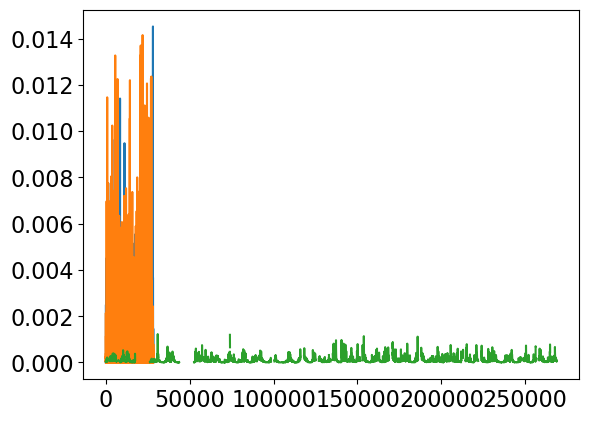

In [7]:
plt.plot(precip)
plt.plot(pet*3600)
plt.plot(q)

## Run Normal CFE Simulations

In [8]:
filename = f"cat_{basin_id}_bmi_config_cfe.json"
cfe_instance = bmi_cfe.BMI_CFE(cfg_file=os.path.join(data_dir, filename), soil_scheme=soil_scheme, partitioning_scheme=partitioning_scheme)
cfe_instance.stand_alone = 0
cfe_instance.initialize()

In [9]:
outputs = cfe_instance.get_output_var_names()
output_lists = {output:[] for output in outputs}

for precip_t, pet_t in zip(precip, pet):
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip_t)
    cfe_instance.set_value("water_potential_evaporation_flux", pet_t)
    
    cfe_instance.update()
    
    for output in outputs:
    
        output_lists[output].append(cfe_instance.get_value(output))

In [10]:
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   0.4978
    volume input:   3.8555
   volume output:   3.8494
    final volume:   0.5039
        residual: -1.1113e-13

PARTITION MASS BALANCE
    surface runoff:   0.0419
      infiltration:   3.4323
 vol. et from rain:   0.3813
partition residual: -8.9373e-15

GIUH MASS BALANCE
  vol. into giuh:   0.0419
   vol. out giuh:   0.0419
 vol. end giuh q:   0.0000
   giuh residual: 6.9389e-18

SOIL WATER MASS BALANCE
     init soil vol:   0.4976
    vol. into soil:   3.4323
  vol.soil2latflow:   0.3800
   vol. soil to gw:   0.1588
 vol. et from soil:   2.8885
   final vol. soil:   0.5026
  vol. soil resid.: -5.6621e-15

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.3800
  vol. from nash:   0.3794
 final vol. nash:   0.0006
nash casc resid.: 2.1727e-16

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0002
       vol to gw:   0.1588
     vol from gw:   0.1577
final gw.storage:   0.0013
    gw. residual: 3.6791e

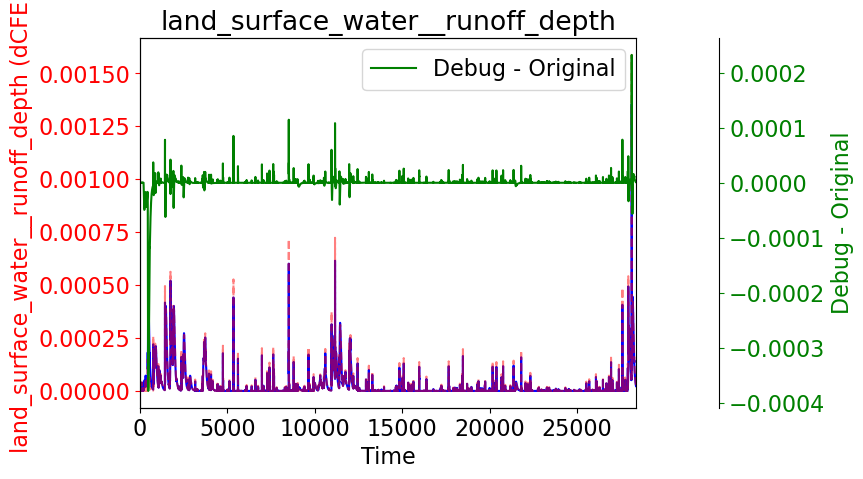

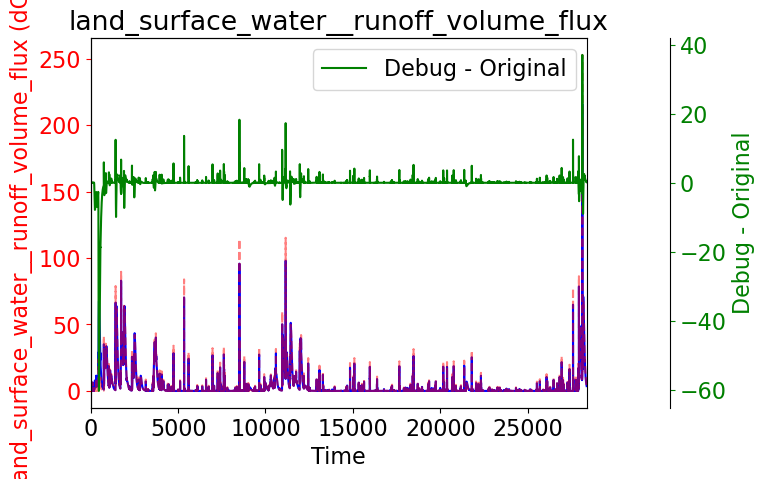

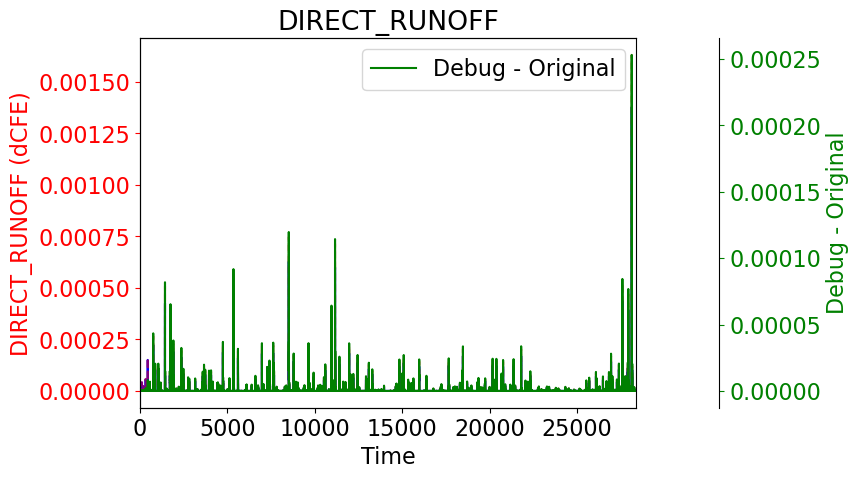

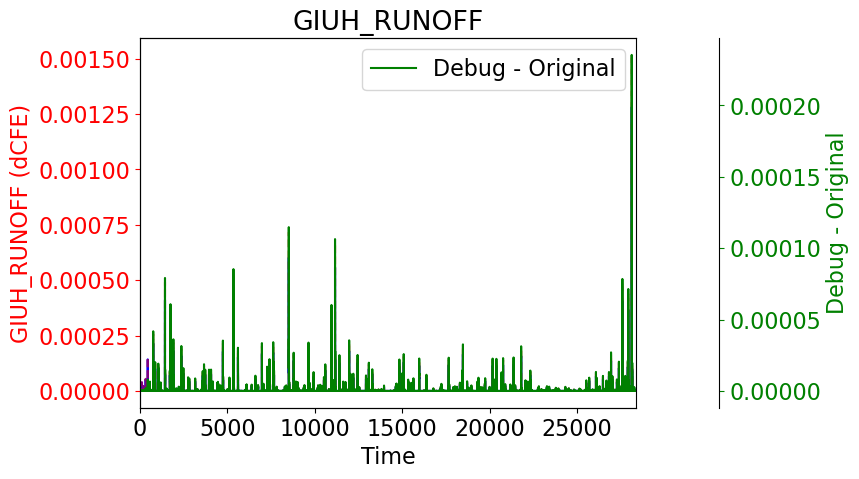

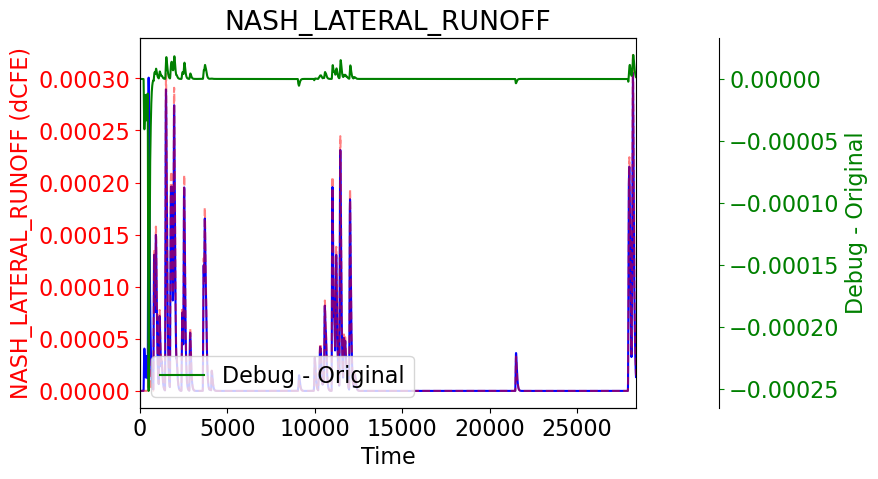

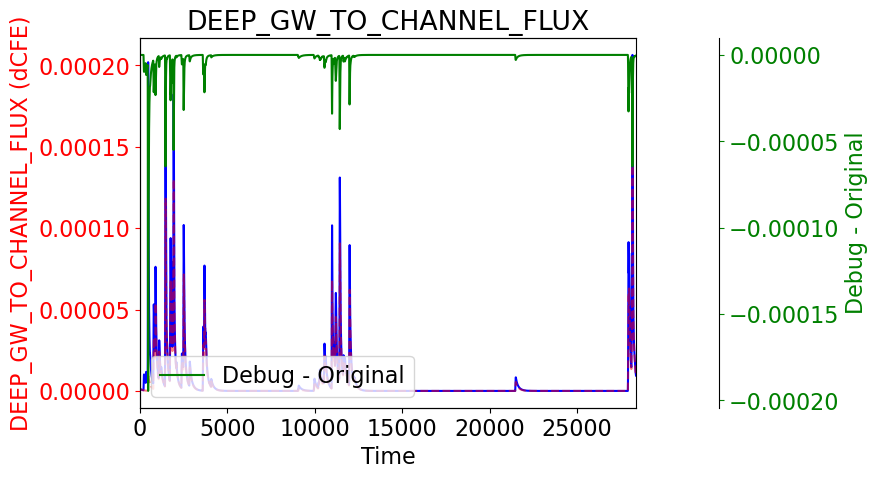

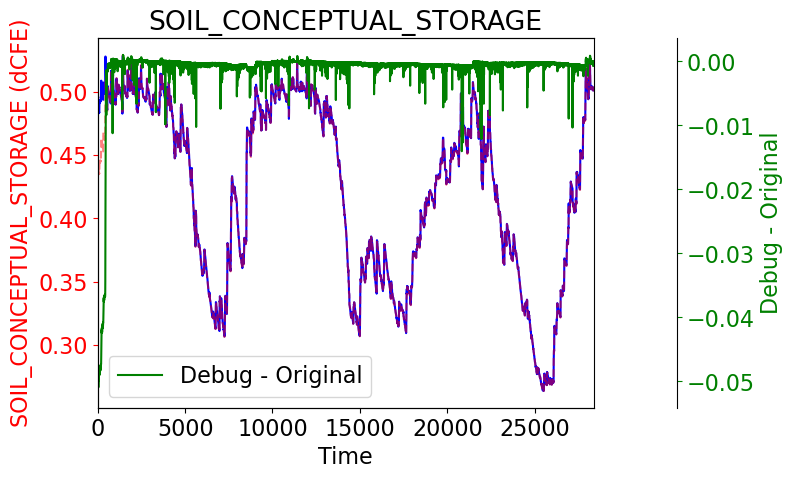

In [11]:
# istart_plot = 490
# iend_plot = 550
# x = list(range(istart_plot, iend_plot))
for output in outputs:
    dCFE_df = pd.read_csv(os.path.join(synthetic_dCFE_dir, f"{output}.csv"))
    dCFE_data = dCFE_df[basin_id].values

    original_data = output_lists[output]

    # Create the main figure and axis
    fig, ax1 = plt.subplots()

    # Plot the original data on the main axis
    ax1.plot(original_data, 'b-', label=f"{output} (Original)", alpha=0.5)
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f"Original", color='b')
    ax1.tick_params('y', colors='b')

    # Create a second y-axis for the dCFE data
    ax2 = ax1
    ax2.plot(dCFE_data, 'r--', label=f"{output} (dCFE)", alpha=0.5)
    ax2.set_ylabel(f"dCFE", color='r')
    ax2.tick_params('y', colors='r')

    # Create a third y-axis for the Debug - Original data
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the right y-axis
    ax3.plot(dCFE_data - original_data, 'g-', label=f"Debug - Original", alpha=0.5)
    ax3.set_ylabel("Debug - Original", color='g')
    ax3.tick_params('y', colors='g')

    plt.title(output)
    plt.legend()
    plt.xlim([0, len(dCFE_data)])
    plt.show()
    plt.close()

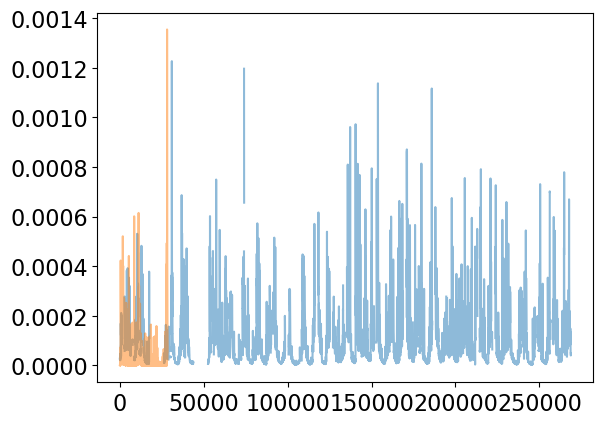

In [12]:
plt.plot(obs_q_["QObs(mm/h)"].values/conversions_m_to_mm, alpha=.5)
plt.plot(output_lists["land_surface_water__runoff_depth"], alpha=.5)

# Save results

In [13]:
sim_q = np.array(output_lists["land_surface_water__runoff_depth"])

In [14]:

# Create a pandas DataFrame from the indexed list
output_df = pd.DataFrame(sim_q, index=forcing_df.index, columns=["simQ[m/hr]"])
output_df.head()

,simQ[m/hr]
time,
1990-10-06 00:00:00,0.000001
1990-10-06 01:00:00,0.000001
1990-10-06 02:00:00,0.000001
1990-10-06 03:00:00,0.000001
1990-10-06 04:00:00,0.000001


In [15]:
filename = f"{basin_id}_synthetic_{soil_scheme}.csv"
output_df.to_csv(os.path.join(output_dir, filename))